<a href="https://colab.research.google.com/github/ABD-01/MNIST/blob/main/Triplet%20Loss/TRIPLET_LOSS_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from itertools import combinations 
 
import tensorflow as tf
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
import torchvision
import torchvision.transforms as transforms

In [ ]:
!pip install torchviz

In [ ]:
!pip install git+https://github.com/waleedka/hiddenlayer.git

In [4]:
# plt.rcParams['figure.figsize'] = (5, 5)

### Triplet Loss

In [5]:
def triplet_loss(anchor, positive, negative, margin=0.2):
    pos_dist = (anchor - positive).pow(2).sum(-1) #.pow(.5)
    neg_dist = (anchor - negative).pow(2).sum(-1) #.pow(.5)
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()
 
# ref: https://github.com/adambielski/siamese-triplet/blob/0c719f9e8f59fa386e8c59d10b2ddde9fac46276/losses.py#L24

In [6]:
def tf_triplet_loss(anchor, positive, negative, margin=0.2):    
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    loss = tf.maximum(pos_dist - neg_dist + margin, 0)
    return tf.reduce_mean(loss)
 
# ref : https://stackoverflow.com/questions/38260113/implementing-contrastive-loss-and-triplet-loss-in-tensorflow/38270293#38270293

In [7]:
torch_triplet_loss = nn.TripletMarginLoss(margin=0.2)

In [8]:
def get_triplets(embeddings:list, targets:list) -> list:
    '''
    Parameters
    ----------
    embeddings : list of torch.tensor
    targets    : list of ints

    Returns
    -------
    triplets   : list of tuple
    '''

    assert len(embeddings) == len(targets) , "Embeddings and Targets must have same lenght"

    triplets = []
    for i, anchor in enumerate(embeddings):

        positive_pairs = list(combinations(anchor,2))  # this will give of distinct pairs of elements 
                                                                 # n(pos_pairs) = no(embeds)P2 / 2!

        temp = embeddings.pop(i)  # embeddings list except the anchor
        for negative_embeddings in torch.cat(embeddings,dim=0):
            
            triple = [(positive_pair[0], positive_pair[1], negative_embeddings) for positive_pair in positive_pairs]

            triplets.extend(triple)

        embeddings.insert(i, temp)
        print(len(embeddings))

    return triplets

In [9]:
MNIST_train = torchvision.datasets.MNIST(
    root = '/content/drive/MyDrive/Colab Notebooks/',
    download = True,
    train = True,
    transform = transforms.ToTensor()
)

In [10]:
MNIST_train.data.shape

torch.Size([60000, 28, 28])

4

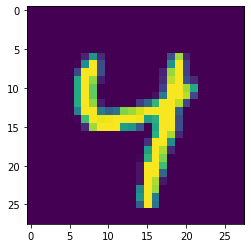

In [11]:
i =5734
plt.imshow(MNIST_train[i][0].squeeze())
MNIST_train[i][1]

## Reorganizing Data

In [12]:
train_dict = {i : MNIST_train.data[MNIST_train.targets == i].unsqueeze(1) / 255 for i in range(10)}
print(*[f'{imgs.shape[0]} images of Label {label} of shape {imgs.shape[1:]}' for label, imgs in train_dict.items()], sep='\n')
# for i in range(10):
#     train_dict[i] = MNIST_train.data[MNIST.targets == i]

5923 images of Label 0 of shape torch.Size([1, 28, 28])
6742 images of Label 1 of shape torch.Size([1, 28, 28])
5958 images of Label 2 of shape torch.Size([1, 28, 28])
6131 images of Label 3 of shape torch.Size([1, 28, 28])
5842 images of Label 4 of shape torch.Size([1, 28, 28])
5421 images of Label 5 of shape torch.Size([1, 28, 28])
5918 images of Label 6 of shape torch.Size([1, 28, 28])
6265 images of Label 7 of shape torch.Size([1, 28, 28])
5851 images of Label 8 of shape torch.Size([1, 28, 28])
5949 images of Label 9 of shape torch.Size([1, 28, 28])


In [13]:
label = 7
rand_imgs = train_dict[label][random.sample(range(1, 5000), 100)]
grid = torchvision.utils.make_grid(rand_imgs, nrow=10, pad_value=20)
# ref: https://pytorch.org/vision/stable/utils.html#torchvision-utils

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


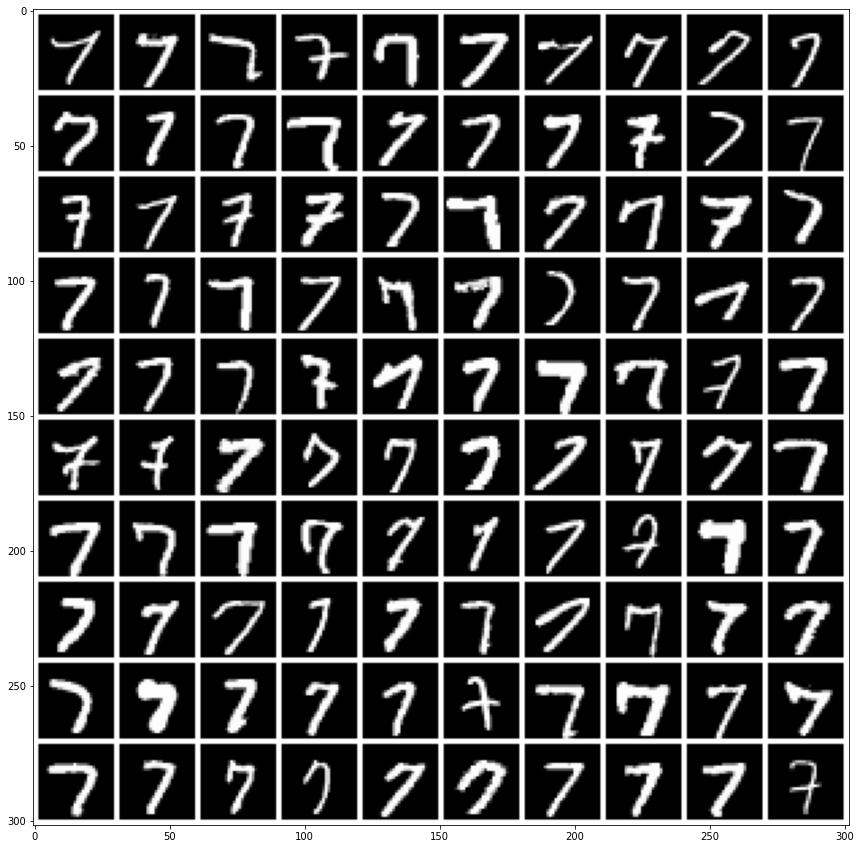

In [14]:
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))

Image Processing 

In [15]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Normalize(mean=0.1307, std=0.3081),
    transforms.Lambda(lambda image: torch.cat((image,image,image), dim=-3)),
])
# ref: https://pytorch.org/hub/pytorch_vision_resnet/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


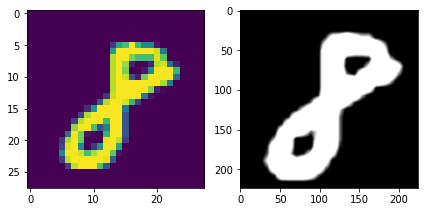

In [16]:
timg = train_dict[8][1]  # shape = (1,28,28)
ptimg = preprocess(timg)  # shape = (3,224,224)

_, axarr = plt.subplots(1,2, figsize = (7,7)) 

axarr[0].imshow(timg.squeeze())

axarr[1].imshow(torch.movedim(ptimg, -3, -1))
#ref : https://pytorch.org/docs/stable/generated/torch.movedim.html

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


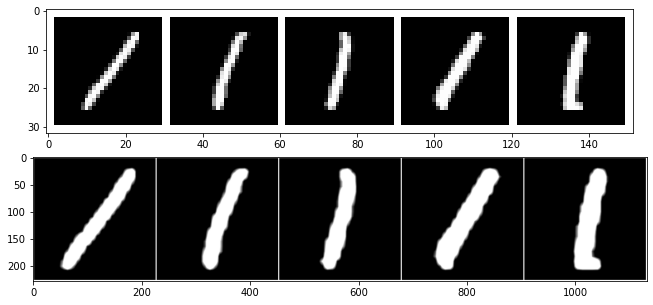

In [17]:
rand_imgs = train_dict[1][random.sample(range(1, 5000), 5)]  # shape = (5,1,28,28)
grid = torchvision.utils.make_grid(rand_imgs, nrow=5, pad_value=20)

prand_imgs = preprocess(rand_imgs)  # shape = (5,3,224,224)
pgrid = torchvision.utils.make_grid(prand_imgs, nrow=5, pad_value=20)

fig , axarr = plt.subplots(2,1, figsize = (15,5)) 

axarr[0].imshow(np.transpose(grid, (1,2,0)))
axarr[1].imshow(np.transpose(pgrid, (1,2,0)))

# Creating Model

In [18]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.preprocess = transforms.Compose([
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                            transforms.Normalize(mean=0.1307, std=0.3081),
                            transforms.Lambda(lambda image: torch.cat((image,image,image), dim=-3)),
                        ])
        # ref: https://pytorch.org/hub/pytorch_vision_resnet/

        self.resnet18 = torchvision.models.resnet18(pretrained=False)
        self.out = nn.Linear(in_features=1000, out_features=128)

    def forward(self, images):
        images = self.preprocess(images)
        images = self.resnet18(images)
        encodings = self.out(images)

        return encodings


In [ ]:
model = Model()
model

In [ ]:
from torchviz import make_dot

x = torch.randn(10,1,28,28)

make_dot(model(x), params=dict(model.named_parameters()))   #.render("rnn_torchviz", format="png")
# ref : https://github.com/szagoruyko/pytorchviz/blob/master/examples.ipynb

In [ ]:
import hiddenlayer as hl

# Build HiddenLayer graph
hl_graph = hl.build_graph(model, torch.zeros([1, 1, 28, 28]))

# Use a different color theme
hl_graph.theme = hl.graph.THEMES["blue"].copy()  # Two options: basic and blue
hl_graph

#ref : https://github.com/waleedka/hiddenlayer/blob/master/demos/pytorch_graph.ipynb

In [24]:
encoding_dict = {}
for i in range(5):
    encoding_dict[i] = model(train_dict[i][:10]) #.detach().numpy()

In [50]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
 
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(3):
        plt.scatter(embeddings[i].detach().numpy()[:,:64],embeddings[i].detach().numpy()[:,64:], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(targets)

In [26]:
[encoding_dict[0], encoding_dict[1], encoding_dict[2]][0].shape

torch.Size([10, 128])

In [27]:
triplets = get_triplets(embeddings=[encoding_dict[0], encoding_dict[1], encoding_dict[2]], targets=[0,1,2])

3
3
3


In [30]:
len(triplets)

2700

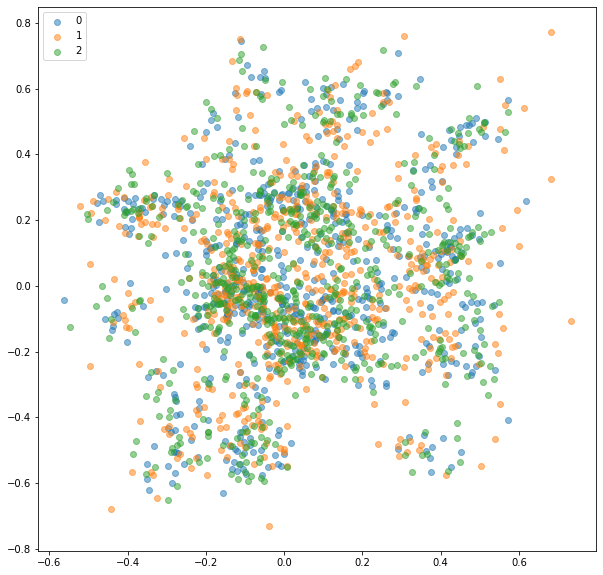

In [51]:
plot_embeddings([encoding_dict[0], encoding_dict[1], encoding_dict[2]], [0,1,2])